The SPLASH model can estimate PPFD using only latitude, longitude, elevation, and the date (year and day of year). 
No additional meteorological data is required for the default calculation of potential PPFD. 
However, if you want more realistic (actual) PPFD, you would need additional inputs such as cloud cover or radiation data.

For more realistic (actual) PPFD calculations, you typically need:
- Incoming shortwave (solar) radiation (e.g., in MJ m⁻² d⁻¹ or W m⁻²)
- Or, total global radiation at the surface
- Optionally, cloud cover fraction or sunshine duration

These data allow SPLASH or similar models to adjust potential PPFD for atmospheric conditions, giving actual PPFD values.

In [18]:
# Install pyrealm if not already installed
# !pip install pyrealm

import numpy as np
import pandas as pd
from pyrealm import splash
from datetime import datetime
import os


# Read csv file for SW_IN_F from file
try:
    df_rad = pd.read_csv('../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2023_1-3.csv')
except FileNotFoundError:
    print("CSV file not found. Please check the file path.")
    raise

# Only take the following columns from the data with TIMESTAMP as date with format YYYY-MM-DD
df_rad = df_rad[['TIMESTAMP', 'SW_IN_F']]
# Convert TIMESTAMP to datetime and set as index
df_rad['TIMESTAMP'] = pd.to_datetime(df_rad['TIMESTAMP'], format='%Y%m%d')
df_rad.set_index('TIMESTAMP', inplace=True)

# Define the location and elevation
latitude = 47.286417
longitude = 7.733750
elevation = 452  # meters

# Date range
start_date = "2004-01-01"
end_date = "2023-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Prepare input DataFrame for SPLASH
df = pd.DataFrame({
    'date': dates,
    'year': dates.year,
    'doy': dates.dayofyear,
    'latitude': latitude,
    'longitude': longitude,
    'elevation': elevation
})

# Merge SW_IN_F (W m-2) into df by date
df = df.merge(df_rad, left_on='date', right_index=True, how='left')

# Convert SW_IN_F from W m-2 to MJ m-2 d-1: 1 W m-2 = 0.0864 MJ m-2 d-1 (for daily mean)
df['SW_IN_F_MJ'] = df['SW_IN_F'] * 0.0864

# Calculate PPFD from SW_IN_F if available, otherwise use SPLASH
# Conversion: 1 W m-2 ≈ 2.04 μmol m-2 s-1 (for PAR, assuming 45% of SW is PAR, and 4.57 μmol/J)
# For daily sum: PPFD (mol m-2 d-1) = SW_IN_F (W m-2) * 0.45 * 4.57 * 86400 / 1e6
def sw_to_ppfd(sw):
    # sw: W m-2 (daily mean)
    if pd.isna(sw):
        return np.nan
    return sw * 0.45 * 4.57 * 86400 / 1e6

df['ppfd_obs'] = df['SW_IN_F'].apply(sw_to_ppfd)

# Calculate PPFD: use observed if available, otherwise SPLASH
ppfd = []
for i, row in df.iterrows():
    if not pd.isna(row['ppfd_obs']):
        ppfd.append(row['ppfd_obs'])
    else:
        try:
            result = splash.run_one_day(lat=latitude, lon=longitude, elv=elevation, 
                                       n=row['doy'], year=row['year'], sf=1.0)
            ppfd.append(result['ppfd'])
        except Exception as e:
            print(f"Error calculating SPLASH for {row['date']}: {e}")
            ppfd.append(np.nan)

df['ppfd'] = ppfd

# Show first few rows
print(df[['date', 'SW_IN_F', 'ppfd_obs', 'ppfd']].head())

# Create output directory if it doesn't exist
output_dir = '../data/01_data_prep'
os.makedirs(output_dir, exist_ok=True)

# save the DataFrame to a CSV file
df.to_csv(os.path.join(output_dir, '03b_splash_ppfd.csv'), index=False)
print(f"Data saved to {output_dir}/03b_splash_ppfd.csv")

        date  SW_IN_F  ppfd_obs      ppfd
0 2004-01-01   36.666  6.514874  6.514874
1 2004-01-02   40.078  7.121123  7.121123
2 2004-01-03   40.147  7.133383  7.133383
3 2004-01-04   53.699  9.541324  9.541324
4 2004-01-05   37.888  6.732000  6.732000
Data saved to ../data/01_data_prep/03b_splash_ppfd.csv


The code uses the `SW_IN_F` column (shortwave incoming radiation in W m⁻²) as follows:

1. It reads `SW_IN_F` from your CSV file and merges it with the date DataFrame.
2. It converts `SW_IN_F` to daily PPFD (`ppfd_obs`) using a standard formula:
   - Assumes 45% of SW_IN_F is PAR (photosynthetically active radiation).
   - Converts energy to photon flux using 4.57 μmol/J.
   - Calculates daily sum in mol m⁻² d⁻¹.
3. For each day, if `SW_IN_F` is available (not NaN), the code uses the calculated `ppfd_obs` as the PPFD value.
4. If `SW_IN_F` is missing (NaN), the code falls back to the SPLASH model estimate for that day.

This ensures that observed radiation data is used when available, and SPLASH is only used to fill gaps.

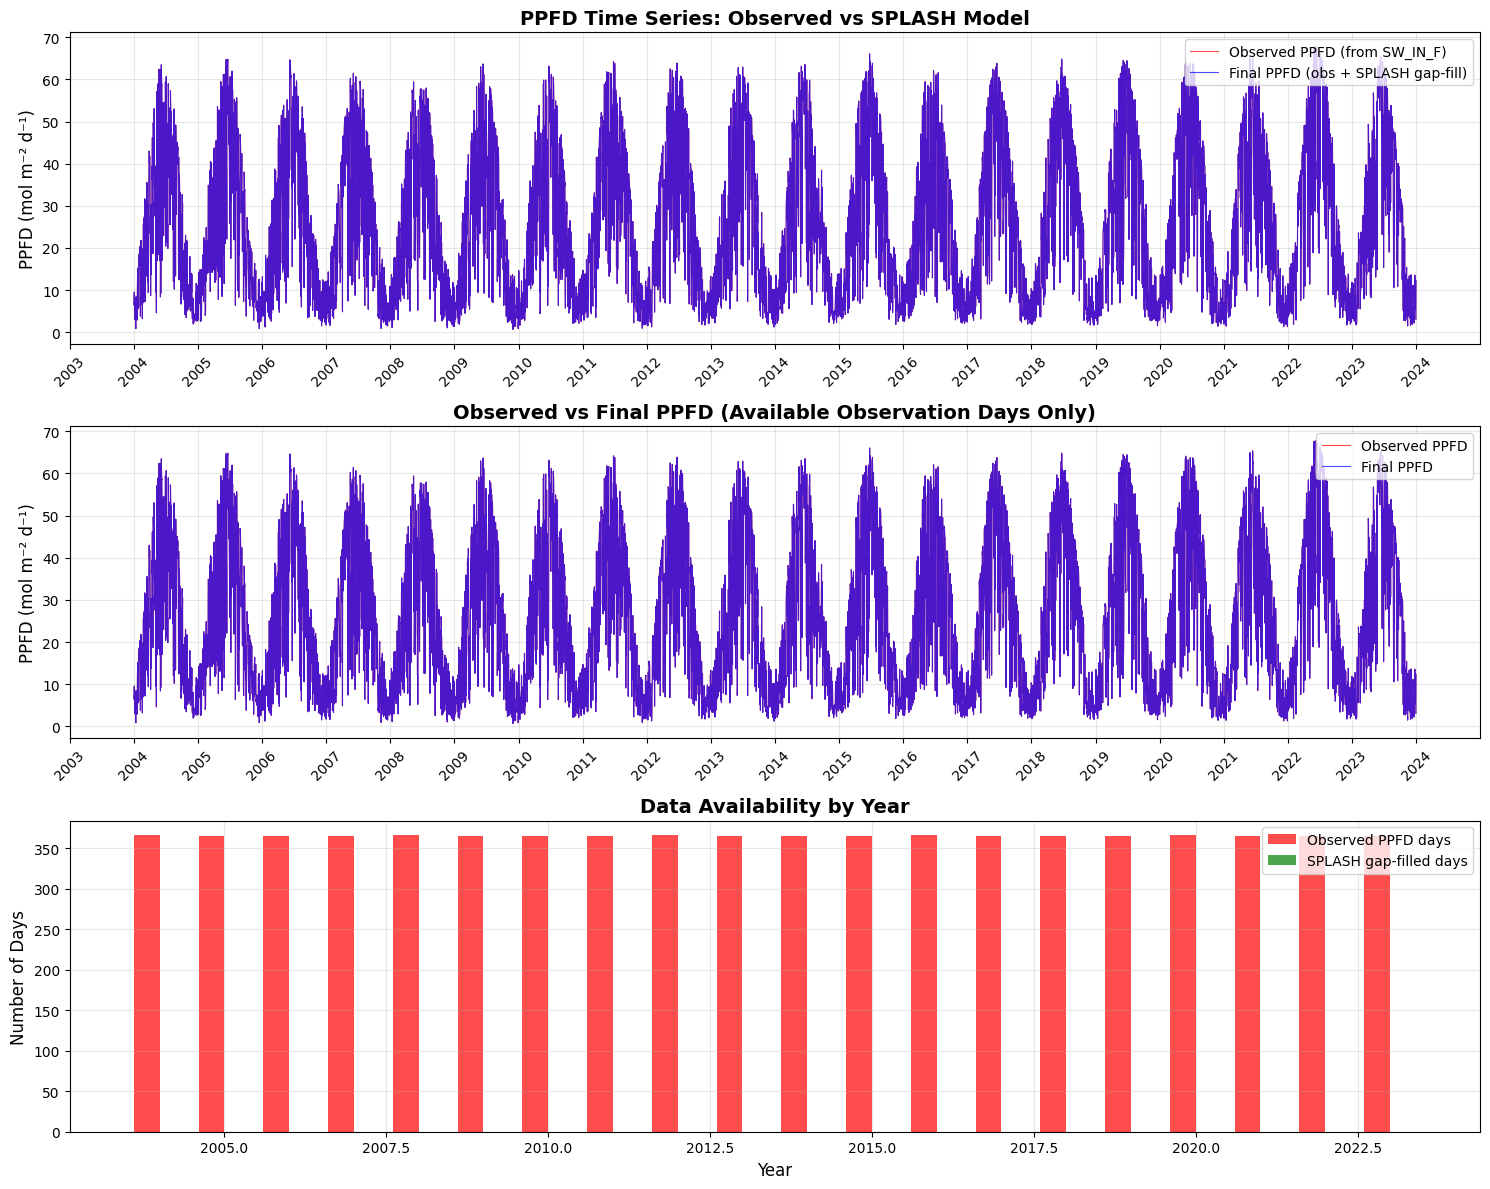


=== PPFD Data Summary ===
Total days: 7305
Days with observed PPFD: 7305
Days with SPLASH gap-fill: 0
Data coverage: 100.0%

=== PPFD Statistics ===
Observed PPFD:
count    7305.000000
mean       25.617360
std        17.774723
min         0.689938
25%         9.738373
50%        21.829961
75%        39.934650
max        67.796014
Name: ppfd_obs, dtype: float64

Final PPFD (obs + SPLASH):
count    7305.000000
mean       25.617360
std        17.774723
min         0.689938
25%         9.738373
50%        21.829961
75%        39.934650
max        67.796014
Name: ppfd, dtype: float64

Correlation between observed and final PPFD: 1.000


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import YearLocator, DateFormatter

# Set style for better looking plots
plt.style.use('default')
sns.set_palette("husl")

# Add year column for plotting
df['year'] = df['date'].dt.year

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: All PPFD variables comparison
ax1 = axes[0]
ax1.plot(df['date'], df['ppfd_obs'], color='red', alpha=0.7, linewidth=0.8, label='Observed PPFD (from SW_IN_F)')
ax1.plot(df['date'], df['ppfd'], color='blue', alpha=0.7, linewidth=0.8, label='Final PPFD (obs + SPLASH gap-fill)')

# Add SPLASH-only values for comparison
df_splash_only = df[df['ppfd_obs'].isna()].copy()
if len(df_splash_only) > 0:
    ax1.plot(df_splash_only['date'], df_splash_only['ppfd'], color='green', alpha=0.7, 
             linewidth=0.8, label='SPLASH PPFD (gap-filled days)', linestyle='--')

ax1.set_title('PPFD Time Series: Observed vs SPLASH Model', fontsize=14, fontweight='bold')
ax1.set_ylabel('PPFD (mol m⁻² d⁻¹)', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: Observed vs Final PPFD (closer comparison)
ax2 = axes[1]
mask_obs = ~df['ppfd_obs'].isna()
ax2.plot(df.loc[mask_obs, 'date'], df.loc[mask_obs, 'ppfd_obs'], color='red', alpha=0.7, 
         linewidth=0.8, label='Observed PPFD')
ax2.plot(df.loc[mask_obs, 'date'], df.loc[mask_obs, 'ppfd'], color='blue', alpha=0.7, 
         linewidth=0.8, label='Final PPFD')

ax2.set_title('Observed vs Final PPFD (Available Observation Days Only)', fontsize=14, fontweight='bold')
ax2.set_ylabel('PPFD (mol m⁻² d⁻¹)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

# Plot 3: Data availability over time
ax3 = axes[2]
data_availability = df.groupby(df['date'].dt.year).agg({
    'ppfd_obs': lambda x: (~x.isna()).sum(),
    'ppfd': lambda x: (~x.isna()).sum()
}).reset_index()

ax3.bar(data_availability['date'] - 0.2, data_availability['ppfd_obs'], width=0.4, 
        color='red', alpha=0.7, label='Observed PPFD days')
ax3.bar(data_availability['date'] + 0.2, data_availability['ppfd'] - data_availability['ppfd_obs'], 
        width=0.4, color='green', alpha=0.7, label='SPLASH gap-filled days')

ax3.set_title('Data Availability by Year', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Number of Days', fontsize=12)
ax3.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Format x-axis for all plots
for ax in axes[:2]:
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()

# Create output directory for plots if it doesn't exist
plot_dir = '../data/01_data_prep/trend_plots'
os.makedirs(plot_dir, exist_ok=True)

# Save the combined plot
plt.savefig(os.path.join(plot_dir, '03b_ppfd_SPLASH_comparison_plots.png'), 
            dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Create additional summary statistics
print("\n=== PPFD Data Summary ===")
print(f"Total days: {len(df)}")
print(f"Days with observed PPFD: {(~df['ppfd_obs'].isna()).sum()}")
print(f"Days with SPLASH gap-fill: {(df['ppfd_obs'].isna()).sum()}")
print(f"Data coverage: {(~df['ppfd_obs'].isna()).sum() / len(df) * 100:.1f}%")

print("\n=== PPFD Statistics ===")
print("Observed PPFD:")
print(df['ppfd_obs'].describe())
print("\nFinal PPFD (obs + SPLASH):")
print(df['ppfd'].describe())

# Correlation between observed and final PPFD (where both available)
mask_both = ~df['ppfd_obs'].isna()
if mask_both.sum() > 0:
    correlation = df.loc[mask_both, 'ppfd_obs'].corr(df.loc[mask_both, 'ppfd'])
    print(f"\nCorrelation between observed and final PPFD: {correlation:.3f}")

In [ ]:
# Install pyrealm if not already installed
# !pip install pyrealm

import numpy as np
import pandas as pd
from pyrealm import splash
from datetime import datetime
import os


# Read csv file for SW_IN_F from file
try:
    df_rad = pd.read_csv('../data/FLX_CH-Oe2_FLUXNET2015_FULLSET_2004-2023_1-3/FLX_CH-Oe2_FLUXNET2015_FULLSET_DD_2004-2023_1-3.csv')
except FileNotFoundError:
    print("CSV file not found. Please check the file path.")
    raise

# Only take the following columns from the data with TIMESTAMP as date with format YYYY-MM-DD
df_rad = df_rad[['TIMESTAMP', 'SW_IN_F']]
# Convert TIMESTAMP to datetime and set as index
df_rad['TIMESTAMP'] = pd.to_datetime(df_rad['TIMESTAMP'], format='%Y%m%d')
df_rad.set_index('TIMESTAMP', inplace=True)

# Define the location and elevation
latitude = 47.286417
longitude = 7.733750
elevation = 452  # meters

# Date range
start_date = "2004-01-01"
end_date = "2023-12-31"
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Prepare input DataFrame for SPLASH
df = pd.DataFrame({
    'date': dates,
    'year': dates.year,
    'doy': dates.dayofyear,
    'latitude': latitude,
    'longitude': longitude,
    'elevation': elevation
})

# Merge SW_IN_F (W m-2) into df by date
df = df.merge(df_rad, left_on='date', right_index=True, how='left')

# Convert SW_IN_F from W m-2 to MJ m-2 d-1: 1 W m-2 = 0.0864 MJ m-2 d-1 (for daily mean)
df['SW_IN_F_MJ'] = df['SW_IN_F'] * 0.0864

# Calculate PPFD from SW_IN_F if available, otherwise use SPLASH
# Conversion: 1 W m-2 ≈ 2.04 μmol m-2 s-1 (for PAR, assuming 45% of SW is PAR, and 4.57 μmol/J)
# For daily sum: PPFD (mol m-2 d-1) = SW_IN_F (W m-2) * 0.45 * 4.57 * 86400 / 1e6
def sw_to_ppfd(sw):
    # sw: W m-2 (daily mean)
    if pd.isna(sw):
        return np.nan
    return sw * 0.45 * 4.57 * 86400 / 1e6

df['ppfd_obs'] = df['SW_IN_F'].apply(sw_to_ppfd)

# Calculate PPFD: use observed if available, otherwise SPLASH
ppfd = []
for i, row in df.iterrows():
    if not pd.isna(row['ppfd_obs']):
        ppfd.append(row['ppfd_obs'])
    else:
        try:
            result = splash.run_one_day(lat=latitude, lon=longitude, elv=elevation, 
                                       n=row['doy'], year=row['year'], sf=1.0)
            ppfd.append(result['ppfd'])
        except Exception as e:
            print(f"Error calculating SPLASH for {row['date']}: {e}")
            ppfd.append(np.nan)

df['ppfd'] = ppfd

# Show first few rows
print(df[['date', 'SW_IN_F', 'ppfd_obs', 'ppfd']].head())

# Create output directory if it doesn't exist
output_dir = '../data/01_data_prep'
os.makedirs(output_dir, exist_ok=True)

# save the DataFrame to a CSV file
df.to_csv(os.path.join(output_dir, '03b_splash_ppfd.csv'), index=False)
print(f"Data saved to {output_dir}/03b_splash_ppfd.csv")